In [161]:
import sys

import darkdetect
import gmsh
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg
from matplotlib import pyplot as plt

from fem.matrix.load_vector import load_node
from fem.matrix.stiffness_matrix import stiffness_node
from fem.mesh.mesh_2d import make_mesh
from fem.plot.plot_pot import plot_pot
from util.gmsh_model import gmsh_model

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [162]:
## matplotlib settings
if darkdetect.isDark():
    plt.style.use('dark_background')
else:
    plt.style.use('default')

plt.rcParams.update({
    "text.usetex": True
})

## Setup problem
### 1) Mesh generation

In [163]:
cad = gmsh.model.occ
sys.argv.append('-nopopup')

@gmsh_model("unit_square", dim=2, finalize=False, options={"Mesh.MeshSizeFactor": 0.2})
def gen_unit_square():
    p1 = cad.add_point(0, 0, 0)
    p2 = cad.add_point(0, 1, 0)
    p3 = cad.add_point(1, 1, 0)
    p4 = cad.add_point(1, 0, 0)
    l1 = cad.add_line(p1, p2)
    l2 = cad.add_line(p2, p3)
    l3 = cad.add_line(p3, p4)
    l4 = cad.add_line(p4, p1)    
    boundary = cad.add_curve_loop([l1,l2,l3,l4])
    cad.add_plane_surface([boundary])
    cad.synchronize()

@gmsh_model("unit_circle", dim=2, finalize=False, options={"Mesh.MeshSizeFactor": 0.2})
def gen_unit_circle():
    c = cad.add_circle(0,0,0,1)
    boundary = cad.add_curve_loop([c])
    cad.add_plane_surface([boundary])
    cad.synchronize()
    
    
# gen_unit_square()
gen_unit_circle()
msh = make_mesh()

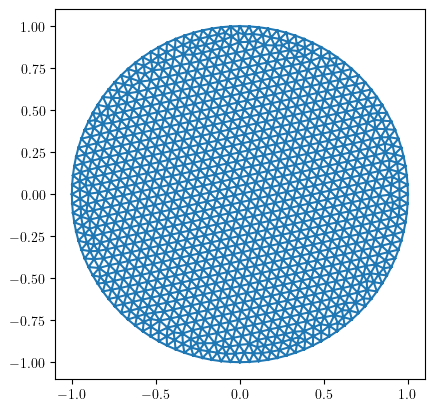

In [164]:
plt.triplot(msh.x, msh.y, msh.elems_to_nodes)
plt.axis('scaled')
plt.show()

### 2) Right hand side - charge distribution

In [194]:
def point_charge(p: np.ndarray):
    return 1 if np.linalg.norm(p) < 2e-2 else 0

q = load_node(msh, point_charge, 1)

### 3) Matrix assembly

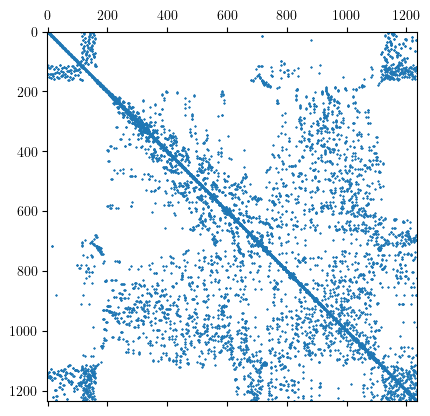

In [195]:
K = stiffness_node(msh)
plt.spy(K, markersize=.5)

## Solve system

In [196]:
phi, info = sp.linalg.gmres(K, q)
print(f"gmres terminated with exit code {info}")

gmres terminated with exit code 12360


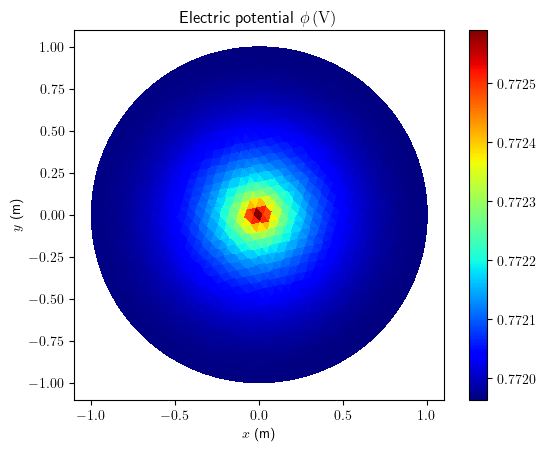

In [202]:
plot_pot(msh, phi, title=r'Electric potential $\phi\,\mathrm{(V)}$', cmap='jet')